# Part 1
##### The below code imports data from the wikipedia page about the dataframe and cleans it into the desired format using web scraping and regular expressions

In [2]:
import pandas as pd
import sklearn as sk
from requests import get
from bs4 import BeautifulSoup
import re

#Scrape wikipedia for the data table
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
response = get(url)
html_soup = BeautifulSoup(response.text, 'html.parser')
divs = html_soup.find_all('table')
table_rows = divs[0].find_all('tr')

#Convert this into a dataframe
dfl = []
for tr in table_rows:
    td = tr.find_all('td')
    row = [tr.text for tr in td]
    dfl.append(row)

df = pd.DataFrame(dfl,columns = ["M1","M2","M3","M4","M5","M6","M7","M8","M9"])

dft = pd.DataFrame(columns = ["PostalCode","Borough","Neighborhood"])

#Reformat a new dataframe in the desired shape
PostalCode = ""
Borough = ""
Neighborhood = ""

for i in range(len(df.columns)):
    for j in range(len(df.iloc[:,i])):
        if(df.iloc[j,i].find("Not assigned")>-1):
            continue
        else:
            PostalCode = re.search("M\d+[A-Z]",df.iloc[j,i]).group(0)
            n = re.search("[(].+[)]",df.iloc[j,i]).group(0)
            Neighborhood = n[1:len(n) - 1]
            b = re.search("\d[\w|\d|\s]+[(]",df.iloc[j,i])
            Borough = b.group(0)[2:len(b.group(0)) - 1]
            dft = dft.append({"PostalCode" : PostalCode,
               "Neighborhood" : Neighborhood,
               "Borough" : Borough},ignore_index = True)

dft["Neighborhood"] = [neighborhood.replace(" /",",") for neighborhood in dft["Neighborhood"]]

##### The dataframe below is the output

In [3]:
print(dft.shape)
dft.head()

(103, 3)


,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


# Part 2

In [3]:
#Import the latitudinal and longitudinal data
ll = pd.read_csv("http://cocl.us/Geospatial_data")
dft["Latitude"] = ll["Latitude"]
dft["Longitude"] = ll["Longitude"]
dft.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


# Part 3

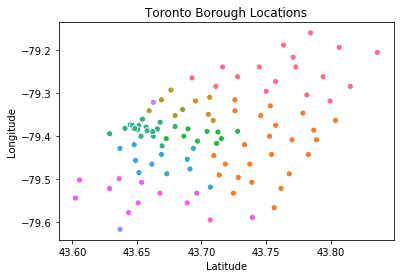

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(x = "Latitude",y = "Longitude", data = dft,
                hue = "Borough",legend = False).set_title("Toronto Borough Locations")


plt.show()

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    branca-0.4.0               |             py_0          26 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    certifi-2019.11.28         |   py36h9f0ad1d_1         149 KB  conda-forge
    folium-0.10.1              |             py_0          59 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    openssl-1.1.1e             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTAL

Text(0.5, 1.0, 'New York Borough Locations')

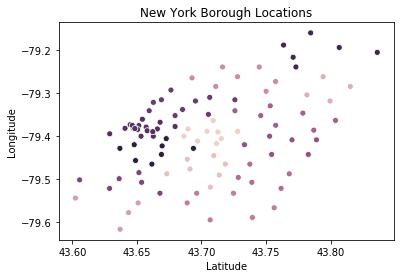

In [28]:
!conda install -c conda-forge folium --yes


#### Create a scree plot to help decide a proper value for 'k' in KMeans

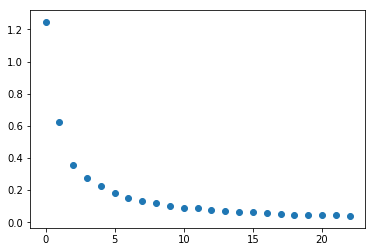

In [20]:
from sklearn import cluster
import numpy as np

error = []

for i in range(1,24):
    km = cluster.KMeans(n_clusters = i)
    km.fit(dft[["Latitude","Longitude"]])
    error.append(km.inertia_)
    
plt.scatter(range(len(error)),error)

#### Cluster neighborhoods using KMeans (k = 4, the approximate best elbow) Based on Latitudinal and Longitudinal data. Then assign each neighborhood a color based on cluster.

In [23]:
k = 4

km = cluster.KMeans(n_clusters = k)
km.fit(dft[["Latitude","Longitude"]])

dft["Cluster"] = km.labels_

colors = ['green', 'blue', 'lightblue', 'red', 'darkred', 'lightred', 'orange', 'pink',
          'purple', 'darkpurple', 'white', 'cadetblue', 'beige', 'darkgreen', 'lightgray', 'black', 'lightgreen', 'darkblue', 'gray']
clusterColor = []

for i in range(len(dft.index)):
    clusterColor.append(colors[dft["Cluster"][i]])
    
dft["Color"] = clusterColor

#### Overlay the results on a folium map of Toronto. Click on the icons for the Borough label

In [24]:
import folium
from folium.plugins import MarkerCluster

nyMap = folium.Map(location = [dft["Latitude"].mean(), dft["Longitude"].mean()],
                   zoom_start = 11)

locations = dft[["Latitude","Longitude"]]
locationlist = locations.values.tolist()

for i in range(len(dft)):
    folium.Marker(locationlist[i],popup = dft["Borough"][i],
                 icon = folium.Icon(color = dft["Color"][i])).add_to(nyMap)

nyMap

#### This version clusters the data together to aid in looking at specific regions as you zoom out.

In [26]:
nyMap2 = folium.Map(location = [dft["Latitude"].mean(), dft["Longitude"].mean()],
                   zoom_start = 11)

locations = dft[["Latitude","Longitude"]]
locationlist = locations.values.tolist()

marker_cluster = MarkerCluster().add_to(nyMap2)

for i in range(len(dft)):
    folium.Marker(locationlist[i],popup = dft["Borough"][i],
                 icon = folium.Icon(color = dft["Color"][i])).add_to(marker_cluster)

nyMap2